In [18]:
import numpy as np
import torch
import torch.nn as nn
d_k = 64
d_v = 64

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def forward(self, Q, K, V, attention_mask):
        #计算注意力得分
        scores = torch.matmul(Q, K.transpose(-1, -2)/np.sqrt(d_k))
        #注意力掩码，将attention_mask中值为1的位置替换为极小值
        scores.masked_fill_(attention_mask, -1e9)
        weights = nn.Softmax(dim=-1)(scores)
        #根据注意力计算带关注度的上下文向量
        context = torch.matmul(weights, V)
        return context, weights

In [19]:
import torch.nn as nn
#定义多头注意力
d_embedding = 512
n_heads = 8
batch_size = 3
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_embedding, d_k*n_heads)
        self.W_K = nn.Linear(d_embedding, d_k*n_heads)
        self.W_V = nn.Linear(d_embedding, d_k*n_heads)
        self.linear = nn.Linear(d_k*n_heads, d_embedding)
        self.layer_norm = nn.LayerNorm(d_embedding)
    
    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        context, weights = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads*d_v)
        output = self.linear(context)
        output = self.layer_norm(output + residual)
        return output, weights

print(MultiHeadAttention())

MultiHeadAttention(
  (W_Q): Linear(in_features=512, out_features=512, bias=True)
  (W_K): Linear(in_features=512, out_features=512, bias=True)
  (W_V): Linear(in_features=512, out_features=512, bias=True)
  (linear): Linear(in_features=512, out_features=512, bias=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [20]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_ff=2048):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_embedding, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_embedding, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_embedding)
    
    def forward(self, inputs):
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1,2)))
        output = self.conv2(output).transpose(1,2)
        output = self.layer_norm(output + residual)
        return output

In [21]:
#定义填充注意力掩码函数
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    return pad_attn_mask

#定义正弦位置编码函数，用于向Transfomer引入位置编码
def get_sin_enc_table(n_position, embedding_dim):
    sinusoid_table = np.zeros((n_position, embedding_dim))
    for pos_i in range(n_position):
        for hid_j in range(embedding_dim):
            angle = pos_i / np.power(10000, 2*(hid_j // 2) / embedding_dim)
            sinusoid_table[pos_i, hid_j]=angle
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask.bool()

In [22]:
import torch.nn as nn
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention()
        self.feed_forward = PoswiseFeedForwardNet()
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)

    def forward(self, dec_inputs, attn_mask=None):
        attn_output, _ = self.self_attn(dec_inputs, dec_inputs, dec_inputs, attn_mask)
        norm1_outputs = self.norm1(dec_inputs + attn_output)
        ff_outputs = self.feed_forward(norm1_outputs)
        dec_outputs = self.norm2(norm1_outputs + ff_outputs)
        return dec_outputs
    

In [23]:
n_layers = 6
class Decoder(nn.Module):
    def __init__(self, vocab_size, max_seq_len):
        super(Decoder, self).__init__()
        self.src_emb = nn.Embedding(vocab_size, d_embedding)
        self.pos_emb = nn.Embedding(max_seq_len, d_embedding)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs):
        positions = torch.arange(len(dec_inputs), device=dec_inputs.device).unsqueeze(-1)
        inputs_embedding = self.src_emb(dec_inputs) + self.pos_emb(positions)
        attn_amsk = get_attn_subsequent_mask(inputs_embedding).to(dec_inputs.device)
        dec_outputs = inputs_embedding
        for layer in self.layers:
            dec_outputs = layer(dec_outputs, attn_amsk)
        return dec_outputs


In [24]:

class GPT(nn.Module):
    def __init__(self, vocab_size, max_seq_len):
        super(GPT, self).__init__()
        self.decoder = Decoder(vocab_size, max_seq_len)
        self.projection = nn.Linear(d_embedding, vocab_size)
    
    def forward(self, dec_inputs):
        dec_outputs = self.decoder(dec_inputs)
        logits = self.projection(dec_outputs)
        return logits


In [25]:
from collections import Counter
import torch
class LanguageCorpus:
    def __init__(self, sentences):
        self.sentences = sentences
        self.seq_len = max([len(sentence.split()) for sentence in sentences]) + 2
        self.vocab = self.create_vocabulary()
        self.idx2word = {v: k for k, v in self.vocab.items()}

    def create_vocabulary(self):
        vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2}
        counter = Counter()
        for sentence in self.sentences:
            words = sentence.split()
            counter.update(words)
        for word in counter:
            if word not in vocab:
                vocab[word] = len(vocab)
        return vocab
    def make_batch(self, batch_size, test_batch=False):
        input_batch, output_batch = [], []
        sentence_indices = torch.randperm(len(self.sentences))[:batch_size]
        for index in sentence_indices:
            sentence = self.sentences[index]
            seq = [self.vocab['<sos>']] + [self.vocab[word] for word in sentence.split()] + [self.vocab['<eos>']]
            seq += [self.vocab['<pad>']] * (self.seq_len - len(seq))
            input_batch.append(seq[:-1])
            output_batch.append(seq[1:])
        return torch.LongTensor(input_batch), torch.LongTensor(output_batch)

In [26]:
with open('.\\data\\lang.txt', 'r') as file:
    sentences = [line.strip() for line in file.readlines()]
corpus = LanguageCorpus(sentences)
vocab_size = len(corpus.vocab)
max_seq_len = corpus.seq_len
print(f"语料词汇表大小：{vocab_size}")
print(f"最大句子长度：{max_seq_len}")


语料词汇表大小：177
最大句子长度：36


Epoch: 0100 cost=0.596990
Epoch: 0200 cost=0.171003
Epoch: 0300 cost=0.101820
Epoch: 0400 cost=0.081737
Epoch: 0500 cost=0.090768


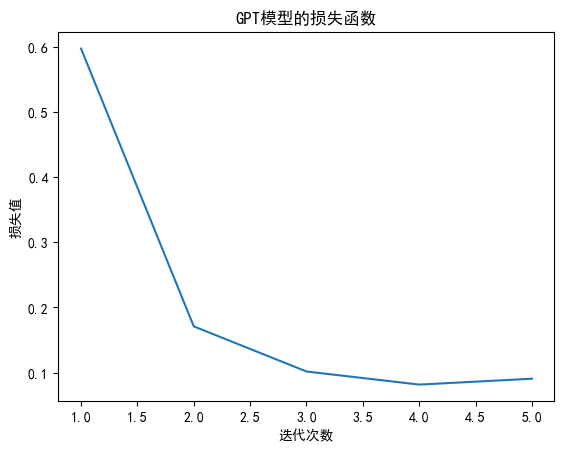

In [27]:
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT(vocab_size, max_seq_len).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 500
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    inputs, targets = corpus.make_batch(batch_size)
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1:04d} cost={loss:.6f}")
        losses.append(loss.item())
    loss.backward()
    optimizer.step()
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, 500//100 + 1), losses)
plt.title('GPT模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()

In [33]:
def generate_text(model, input_str, max_len=50):
    model.eval()
    input_tokens = [corpus.vocab[token] for token in input_str]
    output_tokens = input_tokens.copy()
    with torch.no_grad():
        for _ in range(max_len):
            inputs = torch.LongTensor(output_tokens).unsqueeze(0).to(device)
            outputs = model(inputs)
            _, next_token = torch.max(outputs[:, -1, :], dim=-1)
            next_token = next_token.item()
            if next_token == corpus.vocab['<eos>']:
                break
            output_tokens.append(next_token)
        output_str = " ".join([corpus.idx2word[token] for token in output_tokens])
        return output_str
input_str = ["Language", "models"]
generated_text = generate_text(model, input_str)
print("生成的文本：", generated_text)

生成的文本： Language models have shown impressive capabilities in the past few years by generating diverse and compelling text from human input prompts.
